# Chicago Taxi Trips Analysis

This analysis is done with the aim of providing insights for a ride-hailing service launch team.
One of the key consideration for launching a ride-hailing service is the viability in terms of the value-add that such a service can offer over the existing taxi industry.
Therefore, the approach taken is to identify and point out any potential area of optimization, such as through dynamic pricing and allocation strategies, based on the taxi trips data.
As a general outline, the analysis will look at a higher-level perspective before going deeper into the finer details, while exploring various trends.

### Data Source and Cleaning 

The data is obtained from the Chicago Data Portal which is last updated on September 9, 2021 ([Taxi Trip 2021](https://data.cityofchicago.org/Transportation/Taxi-Trips-2021/9kgb-ykyt)).

A basic cleaning of the data involves the removal of rows with missing or excessively small or large values especially under critical columns, such as fare, trip miles and trip seconds.
The columns corresponding to the trip start and end time are also parsed into datetime format.

In [43]:
import pandas as pd
from functions import cleanData
import datetime
import bokeh

pd.options.display.float_format = '{:,.2f}'.format

# import Taxi Trip data from CSV into DataFrame
cache = {}
def cached_date_parser(s):
    if s in cache:
        return cache[s]
    dt = pd.to_datetime(s)
    cache[s] = dt
    return dt

df_csv =  pd.read_csv("Taxi_Trips_-_2021.csv", parse_dates=[2,3] , infer_datetime_format=True, date_parser=cached_date_parser)

# cleanData
df =  cleanData(df_csv)

## add hour and day of week columns
df['Trip Start Hour'] = df['Trip Start Timestamp'].dt.hour
df['Trip Date'] = df['Trip Start Timestamp'].dt.date
df['Trip Month'] = df['Trip Start Timestamp'].dt.month
df['Trip Day of Week'] = df['Trip Start Timestamp'].dt.dayofweek

## Data Analysis

This analysis is aimed at providing insights to the city launch team using the Chicago Taxi Trips data.
The following analysis can be separated into three components:
- Distributions of key attributes
- Temporal analysis
- Spatial analysis



### Distributions of Key Attributes

#### Trip Fare, Duration and Distance

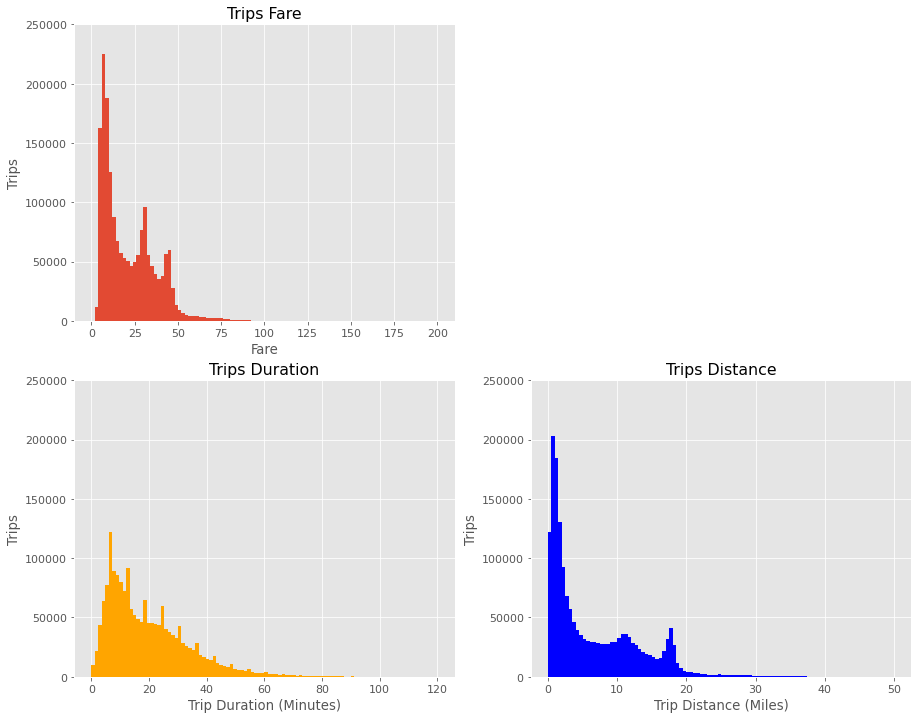

,Fare,Trip Minutes,Trip Miles
count,"1,791,693.00","1,791,693.00","1,791,693.00"
mean,21.61,19.91,6.68
std,15.89,14.83,6.75
min,3.20,0.52,0.06
25%,8.25,8.88,1.30
50%,16.75,16.00,3.90
75%,31.50,27.65,11.04
max,467.84,179.93,99.90


In [3]:
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.size'] = '11'

ymin = 0
ymax = 250000
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,12)
ax[0,1].axis('off')

# distribution of trip duration
df['Trip Minutes'] = df['Trip Seconds'].apply(lambda x : x/60)
ax[1,0].set_xlabel('Trip Duration (Minutes)')
ax[1,0].set_ylabel('Trips')
ax[1,0].set_title('Trips Duration')
ax[1,0].set_ylim([ymin,ymax])
ax[1,0].hist(df['Trip Minutes'], bins = 100,range = [0,120], color = 'orange')

# distribution of trip distance
ax[1,1].set_xlabel('Trip Distance (Miles)')
ax[1,1].set_ylabel('Trips')
ax[1,1].set_title('Trips Distance')
ax[1,1].set_ylim([ymin,ymax])
ax[1,1].hist(df['Trip Miles'],bins = 100,range = [0,50], color = 'blue')

# distribution of fares
ax[0,0].set_xlabel('Fare')
ax[0,0].set_ylabel('Trips')
ax[0,0].set_title('Trips Fare')
ax[0,0].set_ylim([ymin,ymax])
ax[0,0].hist(df['Fare'],bins = 100,range = [0,200])
plt.show()

df[['Fare','Trip Minutes','Trip Miles']].describe()

All three histograms shows a right skewed distribution, with most trips having a relatively low values in terms of fare, duration and distance.
Both fare and distance shows a similar multimodal distribution, indicating the strong correlation between fare and distance.
The three peaks show the relative number of trips based on the distance of the trips, with short-distance trips having a significantly higher number. 

#### Payment Method

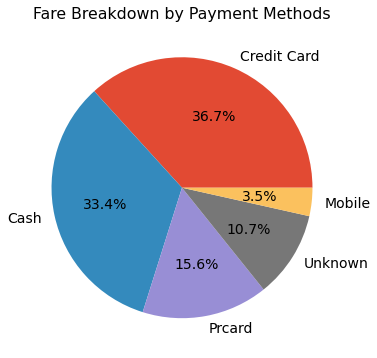

,Fare
Payment Type,
Credit Card,"14,208,634.03"
Cash,"12,908,233.01"
Prcard,"6,042,915.40"
Unknown,"4,152,896.00"
Mobile,"1,353,509.27"
Dispute,"30,309.50"
No Charge,"15,588.50"


In [4]:
# breakdown of payment method
df_payment = df.groupby(['Payment Type']).sum()['Fare']
df_payment = df_payment.sort_values(ascending = False)
data_piechart = df_payment.drop(labels= ['No Charge','Dispute'])

fig, ax = plt.subplots()
fig.set_size_inches(6,6)

ax.set_title('Fare Breakdown by Payment Methods')
ax.pie(data_piechart , labels = data_piechart .index,autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

display(pd.DataFrame(df_payment))

Another attribute of interest is the payment method for the trips.
As shown in the pie chart above, the dominant payment method is by cash and credit card, with both taking up around one-third of the total trips.
The current uptake of modern payment methods, such as credit card and prepaid cards, makes up more than half of the total trips, which could indicate the ease of shifting customers to use electronic payment services that is offered by the ride-hailing service.

### Temporal Analysis
In this section an analysis of the trips based on temporal factors, such as the months, day of the week and hour of day, is presented to reveal the existing trends.

#### Trips by Month

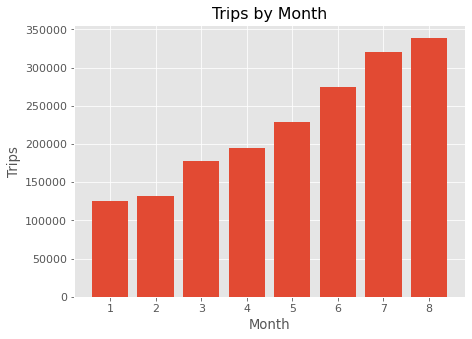

In [5]:
## Trips by month
fig, ax = plt.subplots()
fig.set_size_inches(7,5)

ax.set_xlabel('Month')
ax.set_ylabel('Trips')
ax.set_title('Trips by Month')
ax.set_xticks( range(1,9))

ax.bar( range(1,9),df[df['Trip Month'] < 9].groupby(['Trip Month']).size())

plt.show()

The distribution of trips over the month in 2021 shows a clear increasing trend, which reflects the effects of the COVID restrictions imposed in the earlier part of the year and the subsequent recovery of the taxi industry over the recent months.
Based on this observation, the current data may prove insufficient in providing information on the future trends in taxi trips due to the changes brought about by the pandemic.

Assuming that the trips remain stable or continue to increase, the monthly number of trips is likely to stay above 300,000 which is a significantly large market that can accomodate the entry of a ride-hailing service.

#### Time of Day and Day of Week

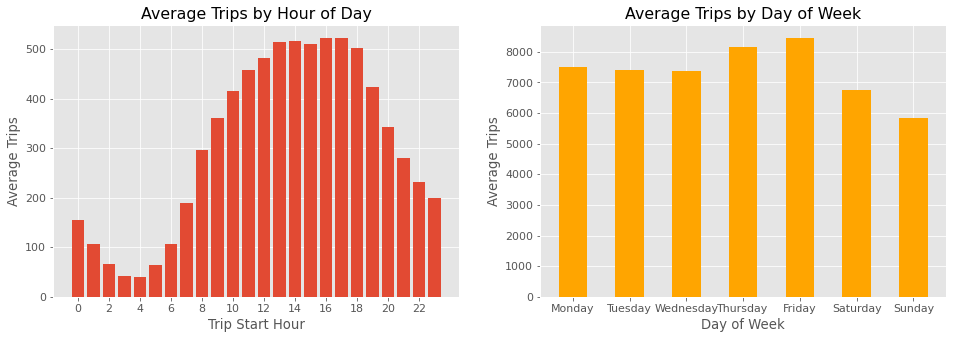

In [6]:
# hour and day analysis
total_days_in_dataset = len(df.groupby(['Trip Date']))
counts_dayOfWeek = df.groupby(['Trip Day of Week'])['Trip Date'].unique().apply(lambda x: len(x))
# distribution of trips within a day; by hour
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax[0].set_xlabel('Trip Start Hour')
ax[0].set_ylabel('Average Trips')
ax[0].set_title('Average Trips by Hour of Day')
ax[0].set_xticks(range(0,24,2))
ax[0].bar(range(0,24),df.groupby(['Trip Start Hour']).size()/total_days_in_dataset)

# distribution of trips based on day of the week    
dayofweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
data_dayofweek = df.groupby(['Trip Day of Week']).size()/counts_dayOfWeek

ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Average Trips')
ax[1].set_title('Average Trips by Day of Week')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(dayofweek)
ax[1].bar(range(7), data_dayofweek, width = 0.5, color = 'orange')

plt.show()

The distribution of trips across the hours of day shows clearly the trips peaking around midday and another peak closer to 6pm.
Under the analysis of trips for each day of the week, it shows Friday as the day with the highest trips and the weekends having a lower number of trips.

These trends indicates the varying demand for taxi services across the day which can be optimized by introducing ride-hailing services, such as improving fulfilment of demands during peak period through differentiated pricing and assignment of customers to drivers.
However, it should be noted that this data only reflects the actual trips that happened, while information of the actual demand and availability of drivers on the road requires more specific data.

#### Trips by Hour for each Day of the Week

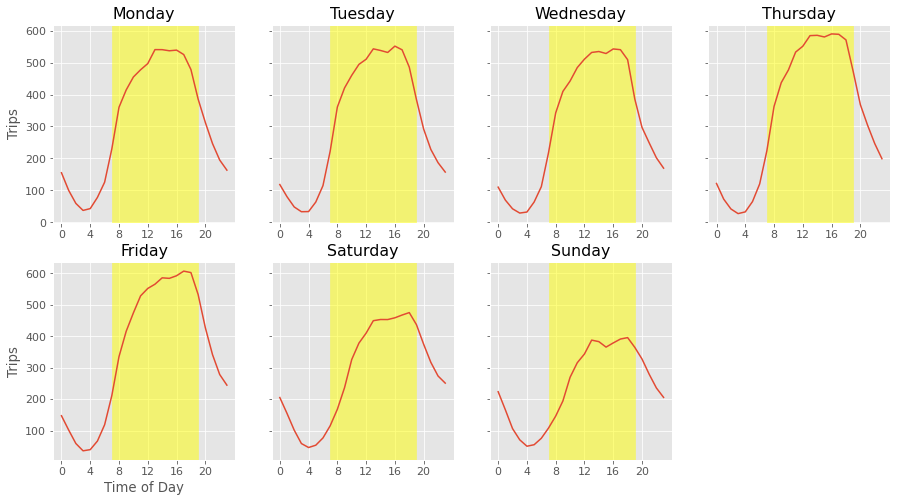

In [8]:
## trip by time of day
plot_data = df.groupby(['Trip Day of Week','Trip Start Hour']).size()
fig, axs = plt.subplots(2,4,sharey='row', figsize=(15,8))
axs[-1, -1].axis('off')
dayofweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

axs[0,0].set_ylabel('Trips')
axs[1,0].set_ylabel('Trips')
axs[1,0].set_xlabel('Time of Day')
day = 0
for r in range (2):
    for c in range (4):
        if(day < 7): 
            axs[r,c].set_title(dayofweek[day])
            axs[r,c].plot(plot_data[day]/counts_dayOfWeek[day])
            axs[r,c].set_xticks( range(0,24,4))
            axs[r,c].axvspan(7, 19,color='yellow', alpha=0.5 )
            day = day + 1
plt.show()


Breaking down the time of day for each day of the week reveals a similar pattern of trips across the week.
An observation that can be made here is that the increase in trips for the weekends happened later in the day with a higher number of trips at midnight.
These different trends across the week also offers an advantage for ride-hailing services to provide information that could help the drivers to maximize the income while avoiding idle rides during offpeak periods.

### Taxi's Perspective

In this final portion of the temporal analysis, the average trips and fares per taxi over the day and the week is presented to understand the trends in fares and trips as experienced by the drivers.

#### Trips per Taxi

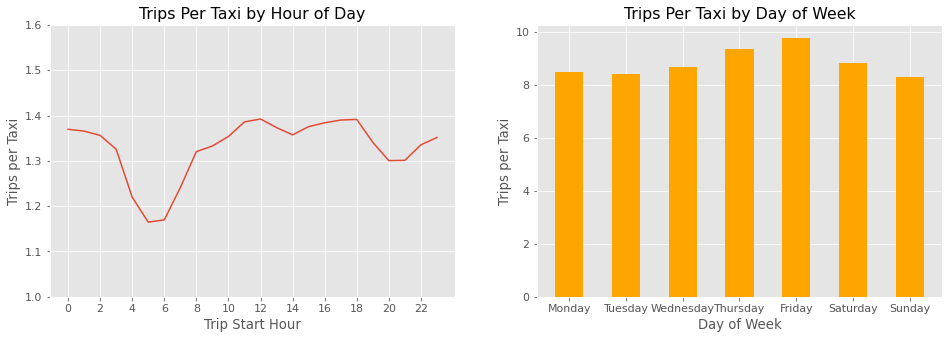

In [24]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

# distribution of trips within a day; by hour
ax[0].set_xlabel('Trip Start Hour')
ax[0].set_ylabel('Trips per Taxi')
ax[0].set_title('Trips Per Taxi by Hour of Day')
ax[0].set_xticks( range(0,24,2))
ax[0].set_ylim( [1,1.6])
ax[0].plot(df.groupby(['Trip Start Hour','Taxi ID','Trip Date']).size().groupby(['Trip Start Hour','Taxi ID']).mean().groupby(['Trip Start Hour']).mean())

## distribution of trips based on day of the week    
datataxitrip_dayofweek = df.groupby(['Trip Day of Week','Taxi ID','Trip Date']).size().groupby(['Trip Day of Week','Taxi ID']).mean().groupby(['Trip Day of Week']).mean()
ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Trips per Taxi')
ax[1].set_title('Trips Per Taxi by Day of Week')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(dayofweek)
ax[1].bar(range(7), datataxitrip_dayofweek, width = 0.5, color = 'orange')

plt.show()

The average trips served per taxi over the day shows a similar pattern to the total trips over the day for most part of the day. The obvious difference can be seen between 8pm to 2am whereby the average trips per taxi is comparable to the peak period despite the lower total trips at night, which could be due to the lower number of taxis on the road at this timing.

As for the average trips per taxi for each day of the week, no significant difference is observed compared to the trends on the total trips.


#### Fares per Taxi

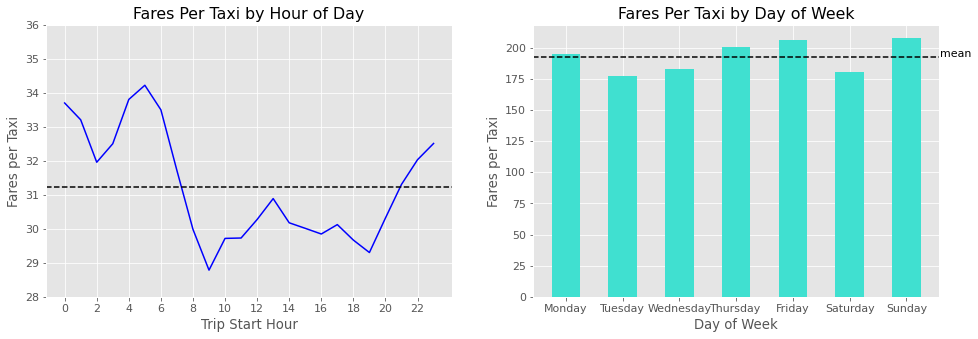

In [25]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

## Fares per taxi
taxifare_perhour = df.groupby(['Trip Start Hour','Taxi ID','Trip Date'])['Fare'].sum().groupby(['Trip Start Hour','Taxi ID']).mean().groupby(['Trip Start Hour']).mean()
mean_fare = taxifare_perhour.mean()
## distribution of fares within a day; by hour
ax[0].set_xlabel('Trip Start Hour')
ax[0].set_ylabel('Fares per Taxi')
ax[0].set_title('Fares Per Taxi by Hour of Day')
ax[0].set_xticks( range(0,24,2))
ax[0].set_ylim( [28,36])
ax[0].plot(taxifare_perhour, color = 'blue')
ax[0].axhline(mean_fare, color = 'black',linestyle = '--')

## distribution fares based on day of the week    
taxifare_dayofweek = df.groupby(['Trip Day of Week','Taxi ID','Trip Date'])['Fare'].sum().groupby(['Trip Day of Week','Taxi ID']).mean().groupby(['Trip Day of Week']).mean()
dailymean_fare= taxifare_dayofweek.mean()
ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Fares per Taxi')
ax[1].set_title('Fares Per Taxi by Day of Week')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(dayofweek)
ax[1].bar(range(7),taxifare_dayofweek, width = 0.5, color = 'turquoise')
ax[1].axhline(dailymean_fare, color = 'black',linestyle = '--')
ax[1].text(6.6,dailymean_fare, 'mean')

plt.show()

Analysis of the fares collected by each taxi over the day shows a higher amount during the night, and is lower during the day.
As for the fares over the week, the fares shows a similar trend to the trips over the week except on Monday and Sunday which sees a higher than average fares earned per taxi.

This information could be helpful for designing the pricing and incentive goals for the drivers and verifying the attractiveness of a ride-hailing service from the perspective of driver recruitment. 
However, such an analysis would require additional study on the population of potential drivers.

### Spatial Analysis

Lastly, a spatial analysis is carried out to understand the trip patterns with respect to the locations in the city.

In [10]:
import math

def LatLongToXY(LatLong_Coords):
    lat = LatLong_Coords[0]
    lon = LatLong_Coords[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

def getMapCoordinates(df_input, coordinateType):
    circle_size_logbase = 1.45
    min_size = 1
    
    coordinate_points = pd.DataFrame()
    
    if(coordinateType == 'Dropoff'):
        df_coordUnique = df_input[df_input['Dropoff Centroid  Location'].notnull()].groupby(['Dropoff Centroid Latitude','Dropoff Centroid Longitude']).size().reset_index()
        df_coordUnique = df_coordUnique.rename(columns = {0:'count'})
        df_coordUnique['Coordinate'] = list(zip(df_coordUnique['Dropoff Centroid Latitude'],df_coordUnique['Dropoff Centroid Longitude']))
    else: #Pickup
        df_coordUnique = df_input[df_input['Pickup Centroid Location'].notnull()].groupby(['Pickup Centroid Latitude','Pickup Centroid Longitude']).size().reset_index()
        df_coordUnique = df_coordUnique.rename(columns = {0:'count'})
        df_coordUnique['Coordinate'] = list(zip(df_coordUnique['Pickup Centroid Latitude'],df_coordUnique['Pickup Centroid Longitude']))

    coordinate_points['x_coord'] = df_coordUnique['Coordinate'].apply(lambda x: LatLongToXY(x)[0])
    coordinate_points['y_coord'] = df_coordUnique['Coordinate'].apply(lambda x: LatLongToXY(x)[1])
    coordinate_points['size'] = df_coordUnique['count'].apply(lambda x: max(math.log(x,circle_size_logbase) + min_size,min_size))
    
    return coordinate_points

In [26]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import row, gridplot
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
tile_provider = get_provider(CARTODBPOSITRON)
output_notebook()

Dropoff_points = getMapCoordinates(df,'Dropoff')
Pickup_points = getMapCoordinates(df,'Pickup')

def generateFigureOfPointsOnMap(CoordinatePointSets,colors, figure_range = [-9780000, -9745000, 5130000, 5160000], 
                                figure_title = '', figure_width= 600,figure_height = 600):
    p = figure(title = figure_title, width=figure_width, height=figure_height,
                x_range=(figure_range[0], figure_range[1]), y_range=(figure_range[2], figure_range[3]),
               x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(tile_provider)
    
    for i in range(len(CoordinatePointSets)):
        p.circle(x = CoordinatePointSets[i]['x_coord'], 
                 y = CoordinatePointSets[i]['y_coord'], 
                 size = CoordinatePointSets[i]['size'],
                 color = colors[i], 
                 alpha = 0.3)
    return p

fig_range = [-9785000, -9745000, 5110000, 5165000];

Loading BokehJS ...

In [18]:
## Dropoff pattern over the day
fig_range = [-9785000, -9745000, 5110000, 5165000]
fig_width = 450
fig_height = 450

# night [24,6)
df_night = df[ (df['Trip Start Hour'] < 6)]
Dropoff_night = getMapCoordinates(df_night,'Dropoff')
DOnight_map = generateFigureOfPointsOnMap([Dropoff_night],['blue'],fig_range, figure_title= '0am-6am Pickup',figure_width=fig_width, figure_height =fig_height)

# morning rush hour [6,12)
df_morning = df[(df['Trip Start Hour'] >= 6) & (df['Trip Start Hour'] < 12)]
Dropoff_morning = getMapCoordinates(df_morning,'Dropoff')
DOmorning_map = generateFigureOfPointsOnMap([Dropoff_morning],['blue'],fig_range, figure_title= '7am-11am Pickup',figure_width=fig_width, figure_height =fig_height)

# noon  [12,18)
df_noon = df[(df['Trip Start Hour'] >= 12) & (df['Trip Start Hour'] < 18)]
Dropoff_noon = getMapCoordinates(df_noon,'Dropoff')
DOnoon_map = generateFigureOfPointsOnMap([Dropoff_noon],['blue'],fig_range, figure_title= '12pm-5pm Pickup',figure_width=fig_width, figure_height =fig_height)

# evening rush hour [18,24)
df_evening = df[(df['Trip Start Hour'] >= 18) & (df['Trip Start Hour'] < 24)]
Dropoff_evening = getMapCoordinates(df_evening,'Dropoff')
DOevening_map = generateFigureOfPointsOnMap([Dropoff_evening],['blue'],fig_range, figure_title= '6pm-11pm Pickup',figure_width=fig_width, figure_height =fig_height)


In [19]:
## Pickup pattern over the day
# night [24,6)
Pickup_night = getMapCoordinates(df_night,'Pickup')
PUnight_map = generateFigureOfPointsOnMap([Pickup_night],['red'],fig_range, figure_title= '0am-6am Dropoff',figure_width=fig_width, figure_height =fig_height)

# morning rush hour [6,12)
Pickup_morning = getMapCoordinates(df_morning,'Pickup')
PUmorning_map = generateFigureOfPointsOnMap([Pickup_morning],['red'],fig_range, figure_title= '7am-11am Dropoff',figure_width=fig_width, figure_height =fig_height)

# noon  [12,18)
Pickup_noon = getMapCoordinates(df_noon,'Pickup')
PUnoon_map = generateFigureOfPointsOnMap([Pickup_noon],['red'],fig_range, figure_title= '12pm-5pm Dropoff',figure_width=fig_width, figure_height =fig_height)

# evening rush hour [18,24)
Pickup_evening = getMapCoordinates(df_evening,'Pickup')
PUevening_map = generateFigureOfPointsOnMap([Pickup_evening],['red'],fig_range, figure_title= '6pm-11pm Dropoff',figure_width=fig_width, figure_height =fig_height)


#### Pickup and Dropoff Trends
A plot of the the pickup points (red) and dropoff points (blue) over the map of Chicago city is generated, with the number of trips associated to each point reflected by the size of the circles.

In [14]:
grid = gridplot([[PUnight_map,DOnight_map], 
                 [PUmorning_map,DOmorning_map], 
                 [PUnoon_map,DOnoon_map], 
                 [PUevening_map,DOevening_map]])

show(grid)

The pickup and dropoff pattern over the day reflect a similar overall observation as the trip by time of day, with least activities in the early morning (0am-6am) and the highest level at day time (12pm-5pm).

A closer look at the pickup and dropoff locations appearing at different part of the day however reveals differences in the distribution of points, with the dropoff being more spread out across the city in the second half of the day.
The pickup and dropoff activities on key landmarks is indicative of the time dependent trends at that location, such as the inbound and outbound flights at the airport (located in the north-western end of the city).

The above spatial information highlights the potential of a ride-hailing service in directing drivers to locations with higher potential demand for different parts of the day.

#### Analysis of the CBD area

Zooming in to the CBD area, the pickup and dropoff patterns are overlap in the same plot over the different period of the day.

In [15]:
## Pickup and dropoff pattern over the day
### generate overlapping map for pickup and dropoff
title = ['0am-6am','7am-11am','12pm-5pm','6pm-11pm']
point_data = [[Dropoff_night,Pickup_night],[Dropoff_morning,Pickup_morning],[Dropoff_noon,Pickup_noon],[Dropoff_evening,Pickup_evening]]
colors = ['blue','red']

In [16]:
#### CBD area
cbd_area = [LatLongToXY([41.82,-87.7])[0],LatLongToXY([41.94,-87.6])[0],LatLongToXY([41.82,-87.7])[1],LatLongToXY([41.94,-87.6])[1]]
PU_DO_cbd =[]
for i in range(4):
    PU_DO_cbd.append(generateFigureOfPointsOnMap(point_data[i],colors, cbd_area, figure_title= title[i],figure_width=fig_width, figure_height =fig_height))

grid = gridplot([[PU_DO_cbd[0],PU_DO_cbd[1]], [PU_DO_cbd[2], PU_DO_cbd[3]]])
show(grid)

It can be observed, especially for the later half of the day (12pm-5pm and 6pm-11pm), that there is a greater number of dropoff at the CBD area as compared to the pickup of passengers. This means there might be a significant number of taxis that will not be able to pickup a passenger, and remain empty, as they leave the CBD. 

The presence of empty taxis offers both a problem and an opportunity for ride-hailing service to allocate customers to drivers, either by varying the price for trips, directing them to areas with highest probability of finding a passenger or enlarging the search area.

### Summary and Conclusion

In summary, the data analysis shows the potential of launching a ride-hailing service in Chicago City mainly due to the various temporal and spatial trends that can benefit from a more efficient allocation of customers and drivers.
The distribution of trips across the day, and the different trend on weekends are just some of the potential temporal trends that can offer useful information for pricing strategies.
As for the spatial trends, the lopsided pickup-dropoff patterns in certain parts of the city could be improved by smarter pricing and allocation of drivers.

However, further studies and collection of data is necessary especially in terms of approximating actual demand since the data used in this analysis only considers actual trips, and lacks information on potential demand by customers who failed to hail a taxi, or the time spent by taxi in their search for customers.
Furthermore, given the severe COVID situation in 2021 and uncertain trajectory in the future, it would be more prudent to carry out an in-depth analysis once the trends stabilize and make a decision based on that data. 